# **Ali Arshad**

# **Physics-Informed Neural Networks (PINNs)**

In [ ]:
%reset -f

Consider the PDE for Option Pricing with Transaction cost on the spatial domain $\mathbf{D}=[0,15]$ and time $t\in[0,1]$.
\begin{align}
    \begin{cases}
        \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV -\kappa \sigma S^2 \sqrt{\frac{2}{\pi \delta t}} |\frac{\partial^2 V}{\partial S^2} = 0 &\quad (t,S)\in[0,1)\times(0,15) \\
        V(1,S) = max\{S-E,0\} = (S-E)^+ &\quad S\in(0,15) \\
           V(t, 0) = Ke^{-rt}, &\quad t \in [0,1),\\
           V(t, 10) = 0, &\quad t \in [0,1).
    \end{cases}
\end{align}
Where $\sigma$ is a measure of the fluctuation (risk) in the asset, and E is strike price.
We solve this model problem \ref{opt_pde} with parameters:
\begin{align}
    \sigma=0.1, r=0.01, E=8, \kappa=0.1, \delta=0.1
\end{align}

In [ ]:
from time import time

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
sigma=tf.constant(0.1,dtype=DTYPE)
r=tf.constant(0.01,dtype=DTYPE)
kapa=tf.constant(0.1,dtype=DTYPE)
dlta=tf.constant(0.1,dtype=DTYPE)
pi=tf.constant(np.pi,dtype=DTYPE)
k=8 #Known as E in our PDE

# Define initial condition
def fun_u_0(x):
  if x-k>0:
    return x-k
  else:
    return 0.0

# Define boundary condition
def fun_u_b1(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def fun_u_b2(t,x):
    return k*tf.exp(-r*t)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + 0.5*(sigma**2)*(x**2)*u_xx + r*x*u_x -r*u - kapa*sigma*(x**2)*tf.sqrt(2/(pi*dlta*t))*tf.abs(u_xx)

In [ ]:
# Set number of data points
N_0 = 700
N_b = 80
N_r = 12000#N_0*N_b

# Set boundary
tmin = 0.
tmax = 1
xmin = 0.
xmax = 15.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
ui=[]
for xi in x_0:
  if fun_u_0(xi)!=0:
    ui.append(fun_u_0(xi).numpy()[0])
  else:
    ui.append(fun_u_0(xi))
tensor = tf.convert_to_tensor(ui)

u_0 = tf.expand_dims(tensor, axis=1)

In [ ]:
# Boundary data
t_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b1 = tf.ones([N_b,1])*lb[1] # + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
t_b2 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b2 = tf.ones([N_b,1])*ub[1] #lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([t_b1, x_b1], axis=1)
X_b2 = tf.concat([t_b2, x_b2], axis=1)

In [ ]:
# x_b1,x_b2

In [ ]:
# Evaluate boundary condition at (t_b,x_b)
u_b1 = fun_u_b1(t_b1, x_b1)
u_b2 = fun_u_b2(t_b2, x_b2)

In [ ]:
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b1, X_b2]
u_data = [u_0, u_b1, u_b2]

In [ ]:
# x_0.shape,X_0.shape, u_0.shape, x_b.shape, X_b.shape, u_b.shape

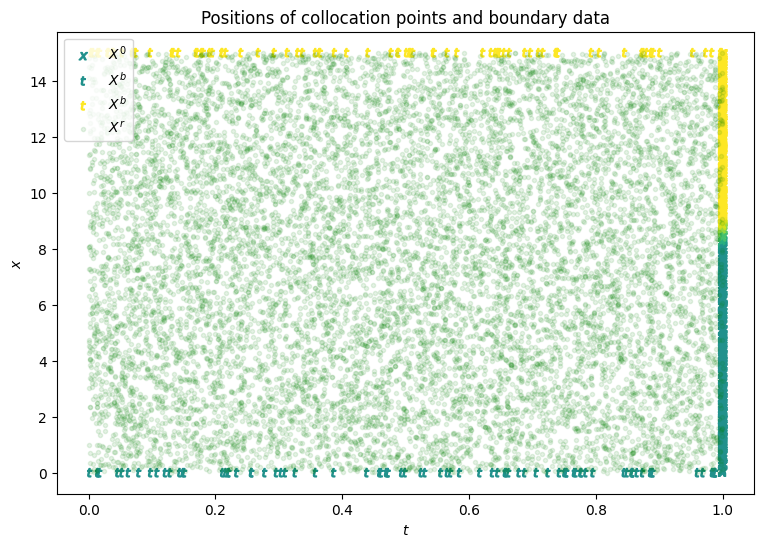

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='$x$', vmin=-1, vmax=1,label=f'$X^0$')
plt.scatter(t_b1, x_b1, c=u_b1, marker='$t$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_b2, x_b2, c=u_b2, marker='$t$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_r, x_r, c='g', marker='.', alpha=0.1,label=f'$X^r$')
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
plt.legend()
plt.show()
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub, output_dim=1, num_hidden_layers=5, num_neurons_per_layer=20,
                 activation='tanh',kernel_initializer='glorot_normal', **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [ ]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss

    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            #tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + 0.5*(sigma**2)*(x**2)*u_xx + r*x*u_x -r*u - kapa*sigma*(x**2)*tf.sqrt(2/(pi*dlta*t))*tf.abs(u_xx)

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [ ]:
0.001,.0001,5e-4

(0.001, 0.0001, 0.0005)

In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
#model.build(input_shape=(None,2))
_ = model(tf.convert_to_tensor([[0.0, 0.0]], dtype=DTYPE))  # Initialize model weights


# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,5000],[0.01,.001,0.0001])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=6001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B'
                             ,options={'maxiter': 1500})#,'ftol':1e-200,'gtol':1e-200})#,'eps':1e10})
                                    #    ,
                                    #  'maxfun': 10000,
                                    #  'maxcor': 10000,
                                    #  'maxls': 10000,
                                    #  'eps': 1e10,
                                    #  'gtol':1e-200
                                    #  ,'ftol': 1e-200})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.90500870e+01
It 00010: loss = 1.22769856e+00
It 00020: loss = 7.43845284e-01
It 00030: loss = 5.12612700e-01
It 00040: loss = 3.66061330e-01
It 00050: loss = 3.10628384e-01
It 00060: loss = 3.00424218e-01
It 00070: loss = 2.73831248e-01
It 00080: loss = 2.68503875e-01
It 00090: loss = 2.58159131e-01
It 00100: loss = 2.50882268e-01
It 00110: loss = 2.44572550e-01
It 00120: loss = 2.33780965e-01
It 00130: loss = 2.23381981e-01
It 00140: loss = 2.16420755e-01
It 00150: loss = 2.13290110e-01
It 00160: loss = 2.08657652e-01
It 00170: loss = 2.03616336e-01
It 00180: loss = 1.95741132e-01
It 00190: loss = 1.87867865e-01
It 00200: loss = 1.80706993e-01
It 00210: loss = 1.75760880e-01
It 00220: loss = 1.71397150e-01
It 00230: loss = 1.64489165e-01
It 00240: loss = 1.48661658e-01
It 00250: loss = 1.43011749e-01
It 00260: loss = 1.33639812e-01
It 00270: loss = 1.25586554e-01
It 00280: loss = 1.15796447e-01
It 00290: loss = 1.08480945e-01
It 00300: loss = 1.05910607e-01
It 00310

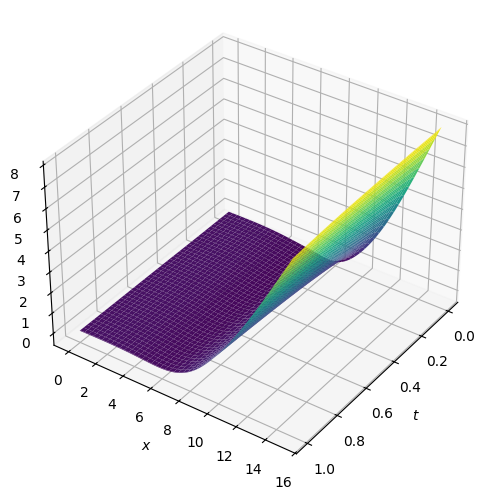

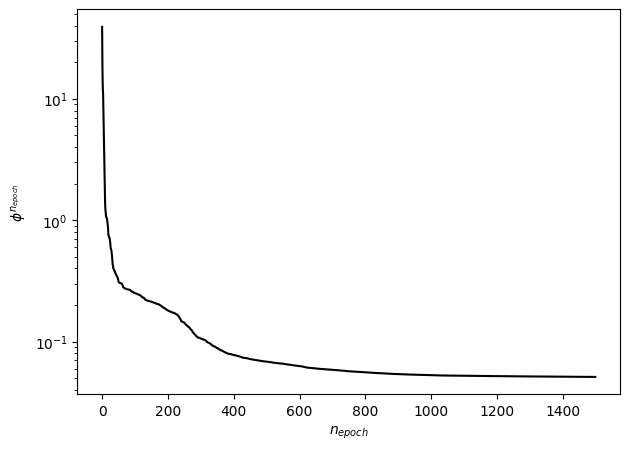

In [ ]:
solver.plot_solution();
solver.plot_loss_history();

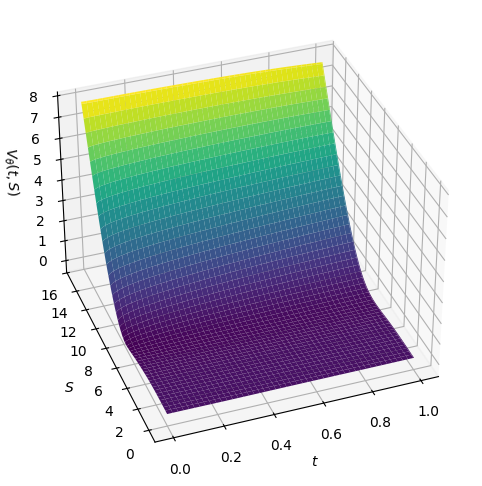

In [ ]:
def plot_solution():
    N = 600
    tspace = np.linspace(lb[0], ub[0], N+1)
    xspace = np.linspace(lb[1], ub[1], N+1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    upred = model(tf.cast(Xgrid,DTYPE))
    U = upred.numpy().reshape(N+1,N+1)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis')#, **kwargs)
    #ax.set_zlim(0, 8)
    #plt.yticks(np.arange(0, 11, 2))
    #plt.xlim(0,0.3)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$S$')
    ax.set_zlabel('$V_\\theta(t,S)$')
    ax.view_init(35,250)
    return ax
plot_solution();